In [1]:
import pandas as pd

# Replace with the correct path to your dataset
file_path = "/Users/rachit/Downloads/city_temperature.csv"  # Update the path

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
print("Dataset loaded successfully!")
print(df.head())
print("Columns in the dataset:", df.columns)

Dataset loaded successfully!
   Region  Country State     City  Month  Day  Year  AvgTemperature
0  Africa  Algeria   NaN  Algiers      1    1  1995            64.2
1  Africa  Algeria   NaN  Algiers      1    2  1995            49.4
2  Africa  Algeria   NaN  Algiers      1    3  1995            48.8
3  Africa  Algeria   NaN  Algiers      1    4  1995            46.4
4  Africa  Algeria   NaN  Algiers      1    5  1995            47.9
Columns in the dataset: Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')


/var/folders/p7/0z8682494dldt4f_vsv6blww0000gn/T/ipykernel_97412/1412813203.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [2]:
# Filter for Delhi
delhi_data = df[df["City"] == "Delhi"]
print("Filtered Delhi data:")
print(delhi_data.head())

# Save filtered data for reuse
delhi_data.to_csv("delhi_temperature.csv", index=False)
print("Filtered data saved as 'delhi_temperature.csv'.")


Filtered Delhi data:
       Region Country State   City  Month  Day  Year  AvgTemperature
340321   Asia   India   NaN  Delhi      1    1  1995            50.7
340322   Asia   India   NaN  Delhi      1    2  1995            52.1
340323   Asia   India   NaN  Delhi      1    3  1995            53.8
340324   Asia   India   NaN  Delhi      1    4  1995            53.7
340325   Asia   India   NaN  Delhi      1    5  1995            54.5
Filtered data saved as 'delhi_temperature.csv'.


In [11]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AutoReg

# Suppress warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Initialize Spark
conf = SparkConf().setMaster("local").setAppName("Weather analysis")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

# Read the dataset directly from a local file
file_path = "/Users/rachit/Downloads/city_temperature.csv"  # Replace with your local file path
df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

print("Dataset Schema:")
df.printSchema()

# Convert to pandas DataFrame
df = df.toPandas()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/04 11:51:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataset Schema:
root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- AvgTemperature: double (nullable = true)



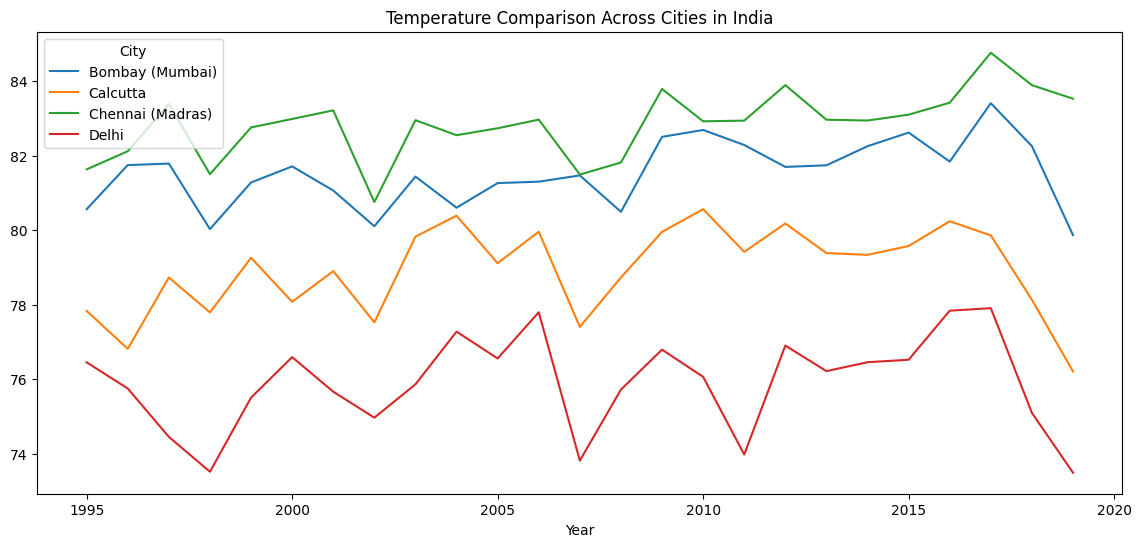

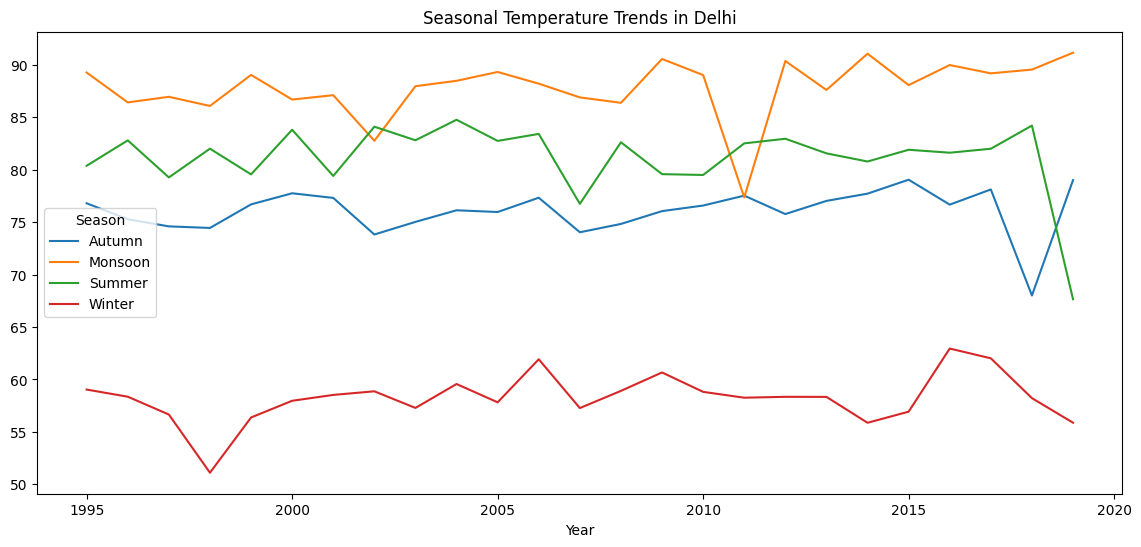

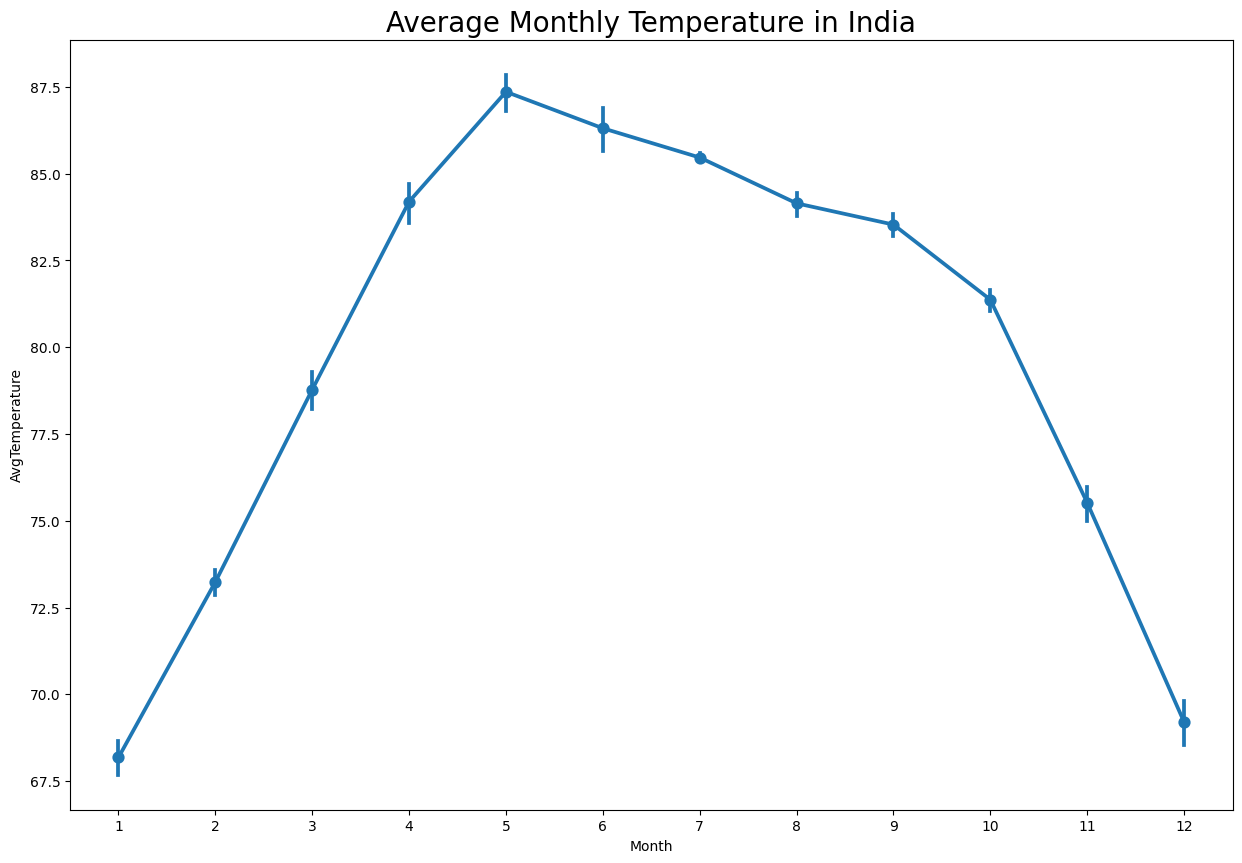

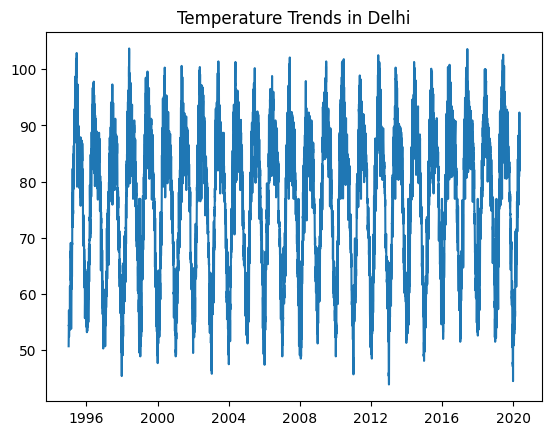

In [15]:
# Filter data for India and exclude data beyond 2020
data_India = df[(df['Country'] == 'India') & (df['Year'] < 2020)]

# Plot for four cities and their temperature comparison
India_plot = data_India.groupby(['City', 'Year'])['AvgTemperature'].mean().reset_index()

# Correct way to use pivot in pandas
India_plot_pivot = India_plot.pivot(index='Year', columns='City', values='AvgTemperature')

# Plot the data
India_plot_pivot.plot(figsize=(14, 6))
plt.title("Temperature Comparison Across Cities in India")
plt.savefig("temperature_comparison_cities.png")
plt.show()

# Define a function to determine the season
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'NA'

data_India['Season'] = data_India['Month'].apply(season)
data_India['AvgTemperature'] = data_India['AvgTemperature'].astype('float64')

# Filter data for Delhi
data_Delhi = data_India[data_India['City'] == 'Delhi']

# Plot seasonal data for Delhi
Delhi_plot = data_Delhi.groupby(['Season', 'Year'])['AvgTemperature'].mean().reset_index()

# Correct way to use pivot in pandas
Delhi_plot_pivot = Delhi_plot.pivot(index='Year', columns='Season', values='AvgTemperature')

# Plot the data
Delhi_plot_pivot.plot(figsize=(14, 6))
plt.title("Seasonal Temperature Trends in Delhi")
plt.savefig("seasonal_temperature_trends.png")
plt.show()

# Average monthly temperature trend in India
plt.figure(figsize=(15, 10))
sns.pointplot(x='Month', y='AvgTemperature', data=data_India)
plt.title('Average Monthly Temperature in India', fontsize=20)
plt.savefig("average_monthly_temperature.png")
plt.show()

# Drop unnecessary columns
df.drop(columns=['State'], inplace=True)

# Filter for Delhi data and reset the index
delhi = df[df["City"] == "Delhi"].reset_index(drop=True)

# Replace outliers with the mean temperature
delhi["AvgTemperature"] = delhi["AvgTemperature"].replace(-99, np.nan)
delhi["AvgTemperature"] = delhi["AvgTemperature"].fillna(delhi["AvgTemperature"].mean())

# Convert to datetime format
delhi['Date'] = pd.to_datetime(delhi[['Year', 'Month', 'Day']])
delhi = delhi.drop(columns=['Region', 'Country', 'City', 'Month', 'Day'])

# Plot Delhi temperature trends
plt.plot(delhi["Date"], delhi["AvgTemperature"])
plt.title("Temperature Trends in Delhi")
plt.savefig("temperature_trends_delhi.png")
plt.show()

# Define training and testing data
training_set = delhi[delhi["Year"] <= 2015]
test_set = delhi[delhi["Year"] > 2015]



root
 |-- Region: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- AvgTemperature: double (nullable = true)



25/01/04 12:02:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/04 12:02:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


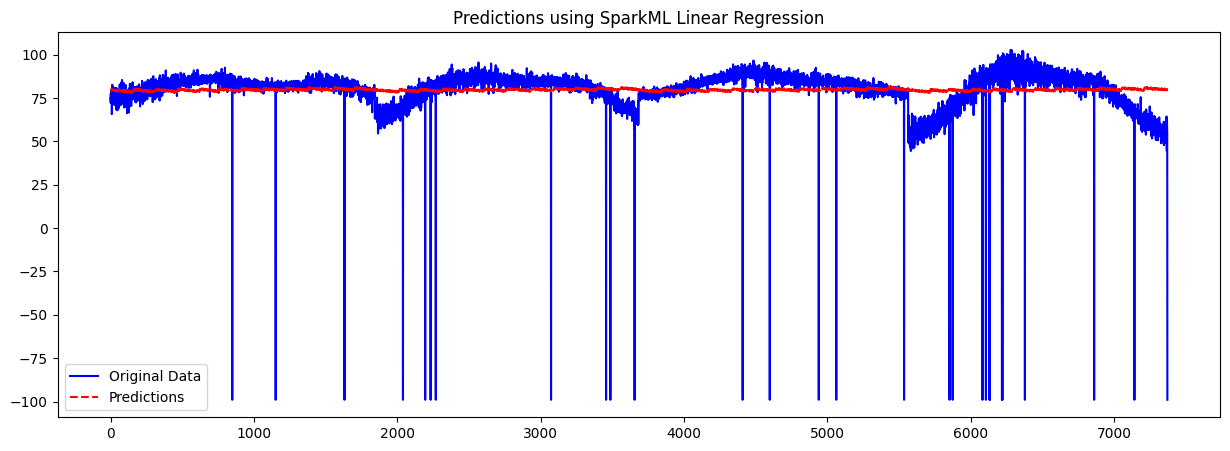

RMSE: 13.974027482204448


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("Weather Analysis with SparkML").getOrCreate()

# Load your data into a Spark DataFrame (assuming CSV file)
data_path = "/Users/rachit/Downloads/city_temperature.csv"  
df = spark.read.option("header", "true").csv(data_path, inferSchema=True)

# Check the schema of the loaded data
df.printSchema()

# Preprocess the data
# Filter for India and before 2020
data_India = df.filter((df['Country'] == 'India') & (df['Year'] < 2020))

# Use VectorAssembler to combine features into a single column
assembler = VectorAssembler(inputCols=["Year", "Month", "Day"], outputCol="features")
data_assembled = assembler.transform(data_India)

# Scale the features (optional but recommended for ML models)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)

# Split data into training and test sets
train_data, test_data = data_scaled.randomSplit([0.8, 0.2], seed=123)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="AvgTemperature")

# Hyperparameter tuning using CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Define evaluator
evaluator = RegressionEvaluator(labelCol="AvgTemperature", predictionCol="prediction", metricName="rmse")

# CrossValidator for hyperparameter tuning
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Fit the model
cv_model = cv.fit(train_data)

# Make predictions
predictions = cv_model.transform(test_data)

# Plot the predictions vs original data
plt.figure(figsize=(15, 5))
plt.plot(predictions.select("AvgTemperature").toPandas(), label="Original Data", color="blue")
plt.plot(predictions.select("prediction").toPandas(), label="Predictions", linestyle="--", color="red")
plt.legend()
plt.title("Predictions using SparkML Linear Regression")
plt.show()

# Evaluate the model
rmse = evaluator.evaluate(predictions)
print("RMSE:", rmse)